In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas
import scipy.stats

import hetmech.hetmat
import hetmech.degree_group
import hetmech.degree_weight


%matplotlib inline

In [2]:
hetmat = hetmech.hetmat.HetMat('../../data/hetionet-v1.0.hetmat/')

## Single degree-combination

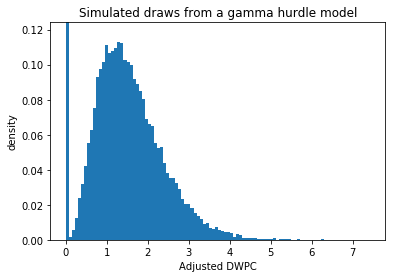

In [3]:
# Draw values from a gamma hurdle model
alpha, beta, p_nz = 4, 2.5, 0.2

num_draws = 100_000
num_nonzero = round(p_nz * num_draws)

draws = scipy.stats.gamma.rvs(alpha, loc=0, scale=1/beta, size=num_nonzero)
draws = numpy.concatenate((draws, numpy.zeros(num_draws - num_nonzero)))

heights, _, _ = plt.hist(draws, bins=100, density=True);
plt.title("Simulated draws from a gamma hurdle model")
plt.xlabel("Adjusted DWPC")
plt.ylabel('density')
plt.ylim((0, 1.1 * max(heights[1:])));

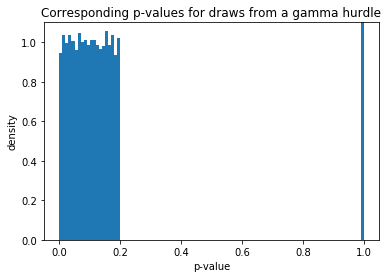

In [4]:
# Plot p-values of simulated gamma hurdle values, expect uniform distribution 
# up to nnz / n with large spike at one
p_values = list()
for draw in draws:
    if draw == 0:
        p = 1
    else:
        p = p_nz * (1 - scipy.stats.gamma.cdf(draw, alpha, 0, 1/beta))
    p_values.append(p)

plt.hist(p_values, bins=100, density=True);
plt.title("Corresponding p-values for draws from a gamma hurdle")
plt.xlabel('p-value')
plt.ylabel('density')
plt.ylim((0, 1.1));

## Example simulated p-values
The p-values of a complete metapath are the combination of p-values from many such partially uniform distributions. When the distribution of all p-values for a single metapath are shown, they are no longer uniformly distributed.

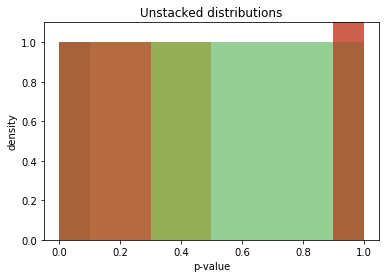

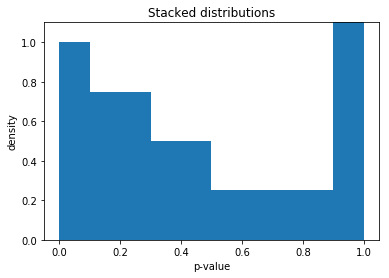

In [5]:
# Without stacking
for frac_nz in {0.0999, 0.2999, 0.4999, 0.8999}:
    values_nz = numpy.linspace(0, frac_nz, round(20*frac_nz))
    values = numpy.concatenate((values_nz, numpy.ones(20 - len(values_nz))))
    plt.hist(values, range=(0, 1), density=True, alpha=0.5, bins=10)
    plt.title("Unstacked distributions")
    plt.xlabel('p-value')
    plt.ylabel('density')
    plt.ylim((0, 1.1));

# With stacking
num_per = 100
total_values = numpy.array([])
for frac_nz in {0.0999, 0.2999, 0.4999, 0.8999}:
    values_nz = numpy.linspace(0, frac_nz, round(num_per*frac_nz))
    total_values = numpy.concatenate((total_values, values_nz, numpy.ones(num_per - len(values_nz))))

plt.figure()
plt.hist(total_values, range=(0, 1), density=True)
plt.title("Stacked distributions")
plt.xlabel('p-value')
plt.ylabel('density')
plt.ylim((0, 1.1));

## Single metapath, all degree combinations

In [6]:
metapath = 'DaGbC'
# metapath = 'CiPCiCtD'

path = hetmat.directory.joinpath('adjusted-path-counts', 'dwpc-0.5', 'adjusted-dwpcs', f'{metapath}.tsv.gz')
df = pandas.read_table(path, compression='gzip')

df.head(2)

,source_id,target_id,source_name,target_name,source_degree,target_degree,path_count,dwpc,n,nnz,n_perms,mean_nz,sd_nz,p_value
0,DOID:0050156,DB00014,idiopathic pulmonary fibrosis,Goserelin,18,2,0,0.0,68400,895,200,3.400429,0.906631,1.0
1,DOID:0050156,DB00035,idiopathic pulmonary fibrosis,Desmopressin,18,5,0,0.0,46000,1478,200,2.987823,0.926291,1.0


In [7]:
n_nnz = df[['n', 'nnz']].values

total_zeros = 0
nonzero_p_values = list()
for n, nnz in n_nnz:
    total_zeros += n - nnz
    nonzero_p_values.extend(numpy.linspace(0, nnz/n, nnz))

nonzero_p_values = numpy.array(nonzero_p_values)

In [8]:
num_bins = 200
bin_width = 1 / num_bins

counts, bins = numpy.histogram(nonzero_p_values, bins=num_bins)

# Add zeros to count
counts[-1] += total_zeros
counts = counts / numpy.mean(counts)

heights, _ = numpy.histogram(df['p_value'], bins=num_bins)
heights = heights / numpy.mean(heights)

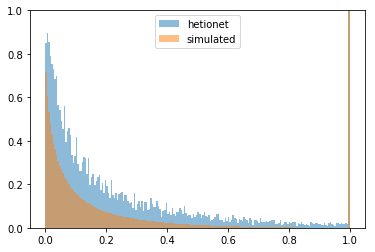

In [9]:
plt.bar(bins[:-1], heights, width=bin_width, align='edge', alpha=0.5, label='hetionet')
plt.bar(bins[:-1], counts, width=bin_width, align='edge', alpha=0.5, label='simulated')
plt.legend()
plt.ylim((0, 1.));

In [10]:
bin_width * sum(counts), bin_width * sum(heights)

(0.9999999999999999, 1.0)

In [11]:
counts[-1], heights[-1]

(188.82736657308823, 174.16566333057418)